# LAB 4 - CART

This lab is comprised of three main sections:

- 1. Classification Trees

- 2. Regression Trees

- 3. Cross-validation

The lab we will dive deeper into the `sklearn` package to make use of algorithms such as Classification Trees (`DecisionTreeClassifier`) and Regression Trees (`DecisionTreeRegressor`).

We will also introduce functions to perform Cross-validation (`GridSearchCV`) on our learners yielding better generalizing models, and helping us select the best hyperparameters

### Load the Data

In [1]:
import numpy as np
import pandas as pd

In [2]:
parole = pd.read_csv("NYCparole.csv")
parole.info()
parole.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6102 entries, 0 to 6101
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Violator    6102 non-null   int64  
 1   Male        6102 non-null   int64  
 2   Age         6102 non-null   float64
 3   TimeServed  6102 non-null   float64
 4   Class       6102 non-null   object 
 5   Multiple    6102 non-null   int64  
 6   InCity      6102 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 333.8+ KB


,Violator,Male,Age,TimeServed,Class,Multiple,InCity
0,0,1,49.4,3.15,D,0,1
1,1,1,26.0,5.95,D,1,0
2,0,1,24.9,2.25,D,1,0
3,0,1,52.1,29.22,A,0,0
4,0,1,35.9,12.78,A,1,1


## 1. CLASSIFICATION TREES

Is CART an appropriate model for classification with Parole data? 

https://datascience.stackexchange.com/questions/6048/decision-tree-or-logistic-regression

### Casting the response variable as Integer

In [3]:
parole['Violator'] = parole['Violator'].astype('int64')

### Dummy Encoding

In previous labs with `statsmodels`, we left the handling of categorical variables to the model.
With `sklearn` packages, we need to do the categorical encoding ourselves.


Two widely used types of categorical encoding are "Dummy Encoding" and "One-hot encoding":
- Dummy encoding converts a variable that has n possible distinct values, into n-1 binary variables. 
- One-hot encoding converts a variable with n possible distinct values, into n binary variables.  

For regression-type problems Dummy Encoding is preferable as we wish to avoid perfect collinearity between the binary variables that are being generated by the encoding. In the classification problem however, we are not concerned about inflating factors and hence can choose either of the two schemes. They will produce equivalent encodings.

We will apply the encoding scheme to the `Class` variable.

In [4]:
parole_enc = pd.get_dummies(parole, columns = ['Class'])

`pd.get_dummies()` can also automatically detect the categorical columns if no specific columns are given

In [5]:
parole_enc.info()
parole_enc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6102 entries, 0 to 6101
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Violator    6102 non-null   int64  
 1   Male        6102 non-null   int64  
 2   Age         6102 non-null   float64
 3   TimeServed  6102 non-null   float64
 4   Multiple    6102 non-null   int64  
 5   InCity      6102 non-null   int64  
 6   Class_A     6102 non-null   uint8  
 7   Class_B     6102 non-null   uint8  
 8   Class_C     6102 non-null   uint8  
 9   Class_D     6102 non-null   uint8  
 10  Class_E     6102 non-null   uint8  
dtypes: float64(2), int64(4), uint8(5)
memory usage: 316.0 KB


,Violator,Male,Age,TimeServed,Multiple,InCity,Class_A,Class_B,Class_C,Class_D,Class_E
0,0,1,49.4,3.15,0,1,0,0,0,1,0
1,1,1,26.0,5.95,1,0,0,0,0,1,0
2,0,1,24.9,2.25,1,0,0,0,0,1,0
3,0,1,52.1,29.22,0,0,1,0,0,0,0
4,0,1,35.9,12.78,1,1,1,0,0,0,0


In [6]:
parole_enc2 = pd.get_dummies(parole, columns = ['Class'],drop_first = True)

In [7]:
parole_enc2.info()
parole_enc2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6102 entries, 0 to 6101
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Violator    6102 non-null   int64  
 1   Male        6102 non-null   int64  
 2   Age         6102 non-null   float64
 3   TimeServed  6102 non-null   float64
 4   Multiple    6102 non-null   int64  
 5   InCity      6102 non-null   int64  
 6   Class_B     6102 non-null   uint8  
 7   Class_C     6102 non-null   uint8  
 8   Class_D     6102 non-null   uint8  
 9   Class_E     6102 non-null   uint8  
dtypes: float64(2), int64(4), uint8(4)
memory usage: 310.0 KB


,Violator,Male,Age,TimeServed,Multiple,InCity,Class_B,Class_C,Class_D,Class_E
0,0,1,49.4,3.15,0,1,0,0,1,0
1,1,1,26.0,5.95,1,0,0,0,1,0
2,0,1,24.9,2.25,1,0,0,0,1,0
3,0,1,52.1,29.22,0,0,0,0,0,0
4,0,1,35.9,12.78,1,1,0,0,0,0


### Splitting the Data

In [8]:
from sklearn.model_selection import train_test_split

y = parole_enc['Violator']
X = parole_enc.drop(['Violator'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,  
                                                    stratify=parole_enc['Violator'],
                                                    random_state=88,)
#By Startify option, each set contains approximately the same percentage of samples 
#of each target class as the complete set. 

X_train.shape, X_test.shape

((4271, 10), (1831, 10))

In [10]:
# BASELINE

negative = np.sum(y_train == 0)
positive = np.sum(y_train == 1)
print(pd.Series({'0': negative, '1': positive}))

0    4037
1     234
dtype: int64


### Decision Tree Classifier

`skelarn`'s `DecisionTreeClassifier` is just one of many implementations that we can use for our classification problem

In [12]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(min_samples_leaf=5, 
                             ccp_alpha= 0.001,
                             criterion = 'gini',
                             random_state = 88)

dtc = dtc.fit(X_train, y_train)

Node count = 17


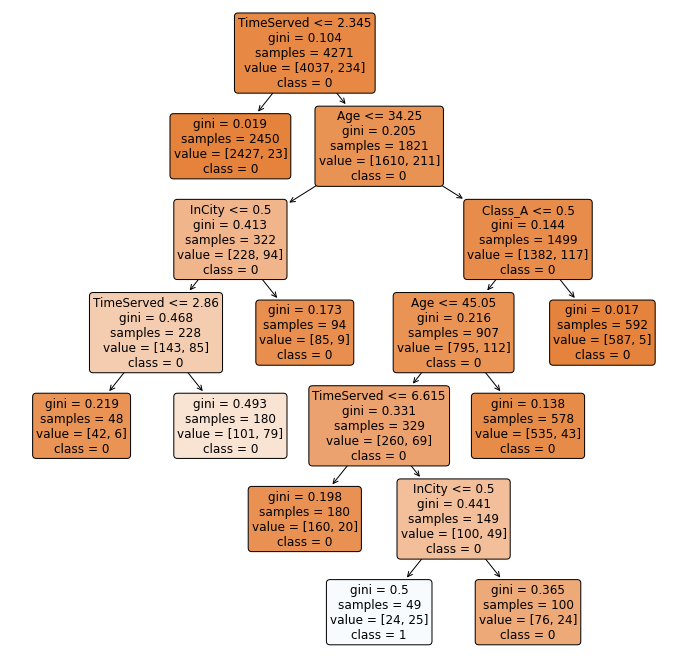

In [13]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

print('Node count =', dtc.tree_.node_count)
plt.figure(figsize=(12,12))
plot_tree(dtc, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12) 
plt.show()

### Pruning

Node count = 5


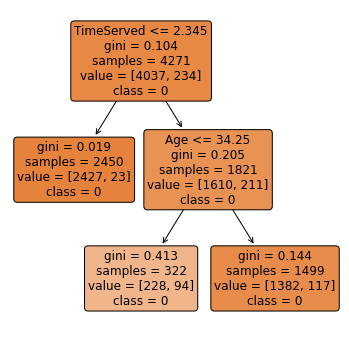

In [14]:
# Try increasing the complexity parameter to prune the tree
# sklearn uses same impurity function in both training and pruning phases

dtc2 = DecisionTreeClassifier(min_samples_leaf=5, 
                              ccp_alpha=0.005,
                              random_state = 88)

dtc2 = dtc2.fit(X_train, y_train)

print('Node count =', dtc2.tree_.node_count)
plt.figure(figsize=(6,6))
plot_tree(dtc2, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12)  
plt.show() 

In [15]:
# MAKE PREDICTIONS 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#Recall is also called sensitiviy or TPR := tp / (tp + fn)
#Precision := tp / (tp + fp)

y_pred = dtc2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm)
print('Precision:',precision_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))

Confusion Matrix : 
 [[1730    0]
 [ 101    0]]
Precision: 0.0
Recall: 0.0


C:\Users\Hyungki Im\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can observe that our tree is not able to discern very well between positive cases of `Violator` and negative cases of `Violator`. The highly imbalanced dataset is likely to be one of the reasons why our predictions are heavily tilted towards `Violator = 0`. We will address the class imbalance with the help of a custom loss function. More specifically, we will assign individual weights to each of the classes. 

### Custom Losses and Weights

Ideally we would like to produce a loss function that can reflect specific penalties for the various types of classification choices.

- cost_TP = 0
- cost_TN = 0
- cost_FP = 1
- cost_FN = 20

With the `sklearn`'s implementation of `DecisionTreeClassifier`, we are not able to incorporate directly such a function. However, we can achieve the same result by assigning weights to the classes in a way that it mimics the presence of more observations of the minority class. This will accomplish the goal of rebalancing our model.

Node count = 11


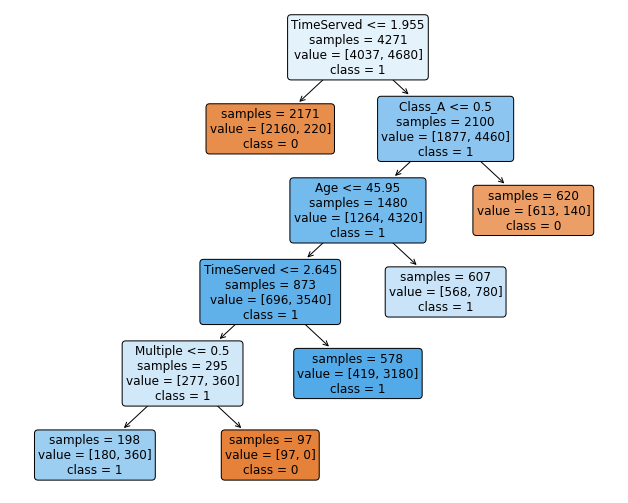

Confusion Matrix : 
 [[1239  491]
 [   7   94]]
Precision: 0.1606837606837607
Recall: 0.9306930693069307


In [16]:
dtc3 = DecisionTreeClassifier(min_samples_leaf=5, 
                              ccp_alpha=0.007,
                              class_weight = {0: 1, 1: 20},
                              random_state = 88)

dtc3 = dtc3.fit(X_train, y_train)

print('Node count =', dtc3.tree_.node_count)
plt.figure(figsize=(11,9))
plot_tree(dtc3, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=12) 
plt.show()

y_pred = dtc3.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm) 
print('Precision:',precision_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))

## 2. REGRESSION TREES

For the Regression Tree example, we use our old wine dataset:

In [17]:
wine = pd.read_csv("../Lab1/wine_agg.csv")
print(len(wine))
wine.head()

46


,Year,LogAuctionIndex,WinterRain,HarvestRain,GrowTemp,HarvestTemp,Age,FrancePop,USAlcConsump
0,1952,7.4950,566.4,165.5,17.28,14.39,63,42.46,7.85
1,1953,8.0393,653.3,75.6,16.94,17.64,62,42.75,8.03
2,1955,7.6858,504.3,129.5,17.30,17.13,60,43.43,7.84
3,1957,6.9845,390.8,110.4,16.31,16.47,58,44.31,7.77
4,1958,6.7772,538.8,187.0,16.82,19.72,57,44.79,7.74


In [18]:
wine_train = wine[wine['Year'] <= 1985]
wine_test = wine[wine['Year'] > 1985]

y_train = wine_train['LogAuctionIndex']
X_train = wine_train.drop(['LogAuctionIndex'], axis=1)
X_train.shape

(31, 8)

### Decision Tree Regressor

In [19]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(min_samples_split=10, 
                            ccp_alpha=0.02,
                            random_state = 88)
dtr = dtr.fit(X_train, y_train)

Node count = 9


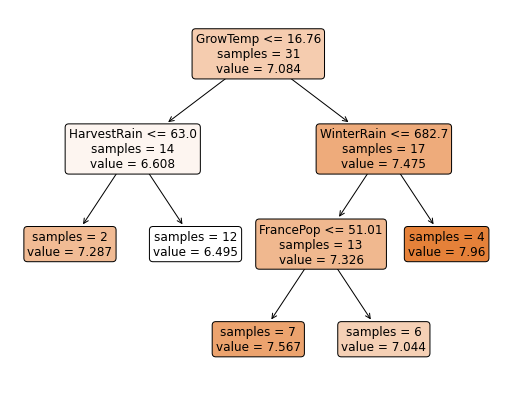

In [20]:
print('Node count =', dtr.tree_.node_count)
plt.figure(figsize=(9,7))
plot_tree(dtr, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=12)
plt.show()

In [21]:
def OSR2(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

In [22]:
y_test = wine_test['LogAuctionIndex']
X_test = wine_test.drop(['LogAuctionIndex'], axis=1)

print('OSR2:', OSR2(dtr, X_test, y_test, y_train))

OSR2: -0.171331426511258


## 3. CROSS-VALIDATION

For the cross-validation example we go back to our classification problem and use the Parole dataset again.

In [23]:
y = parole_enc['Violator']
X = parole_enc.drop(['Violator'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,  
                                                    stratify=parole_enc['Violator'],
                                                    random_state=88,)

### Cross-validation

In [24]:
from sklearn.model_selection import GridSearchCV

#Exhaustive search over specified parameter values for an estimator.

grid_values = {'ccp_alpha': np.linspace(0.0, 0.10, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'class_weight' : [{0: 1, 1: 20}],
               'random_state': [88]} 
            
dtc = DecisionTreeClassifier()
dtc_cv_acc = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=10, verbose=1) 
# default scoring metric to optimize is accuracy, used as default if none given.
dtc_cv_acc.fit(X_train, y_train)

Fitting 10 folds for each of 201 candidates, totalling 2010 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195,
       0.02  , 0.02...
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ]),
                         'class_weight': [{0: 1, 1: 20}], 'max_depth': [30],
                         'min_samples_leaf': [5], 'min_samples_split': [20],
                         'random_state': [88]},
             scoring='acc

In [33]:
acc = dtc_cv_acc.cv_results_['mean_test_score'] 
# what sklearn calls mean_test_score is the holdout set, i.e. the validation set.
ccp = dtc_cv_acc.cv_results_['param_ccp_alpha'].data

pd.DataFrame({'ccp alpha' : ccp, 'Validation Accuracy': acc}).head(20)

,ccp alpha,Validation Accuracy
0,0,0.841021
1,0.0005,0.840787
2,0.001,0.833059
3,0.0015,0.822525
4,0.002,0.802624
5,0.0025,0.792092
6,0.003,0.781562
7,0.0035,0.769856
8,0.004,0.748779
9,0.0045,0.737069


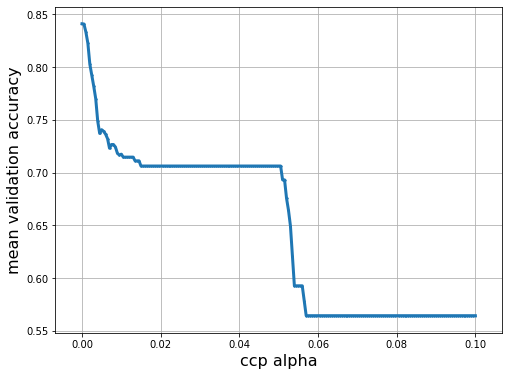

In [34]:
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation accuracy', fontsize=16)
plt.scatter(ccp, acc, s=2)
plt.plot(ccp, acc, linewidth=3)
plt.grid(True, which='both')
plt.show()

MENTION:
One std rule, safety rule: don't hit maximum for validation accuracy, but pick maximizer maximizer minues 1std and move in direction of safer/simpler model.
in DT, increase ccp_alpha. Error in calculation, because of randomness, in order to avoid overfitting, makes senes pick safer model.

In [35]:
print('Grid best parameter ccp_alpha (max. accuracy): ', dtc_cv_acc.best_params_['ccp_alpha'])
print('Grid best score (accuracy): ', dtc_cv_acc.best_score_)

Grid best parameter ccp_alpha (max. accuracy):  0.0
Grid best score (accuracy):  0.8410213618157542


Node count = 241


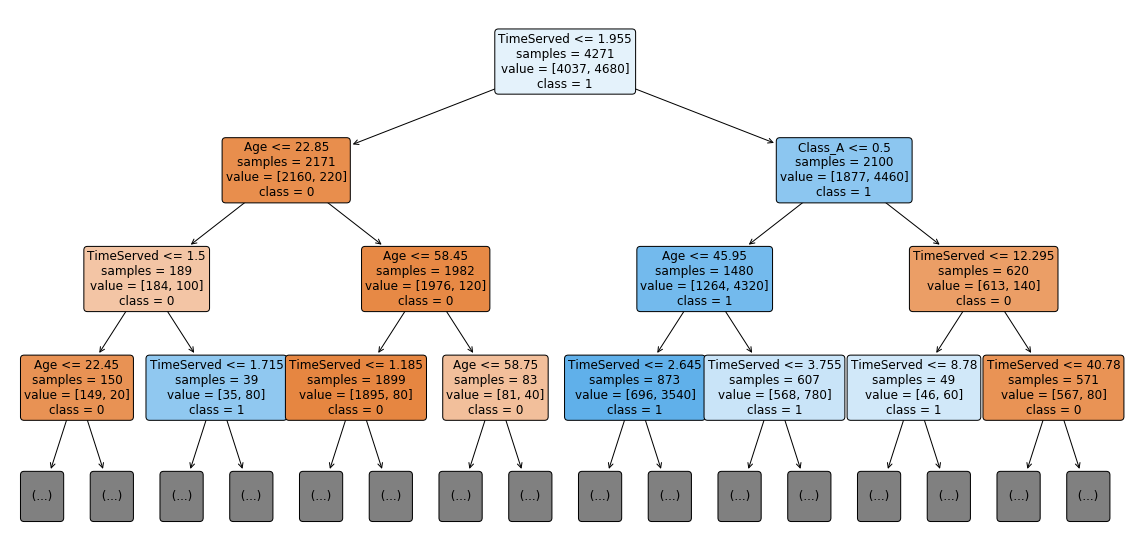

In [36]:
print('Node count =', dtc_cv_acc.best_estimator_.tree_.node_count)

plt.figure(figsize=(20,10))
plot_tree(dtc_cv_acc.best_estimator_, 
          feature_names=X_train.columns, 
          class_names=['0','1'],
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=12,
          max_depth=3)
plt.show()

In [37]:
y_pred = dtc_cv_acc.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm)
print('Precision:',precision_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))

Confusion Matrix : 
 [[1468  262]
 [  30   71]]
Precision: 0.2132132132132132
Recall: 0.7029702970297029


### Cross-validation with Custom Loss Function

In [39]:
def average_loss_function(y_test, y_pred):
    
    weights = np.array([20 if i == 1 else 1 for i in y_test])
    
    return np.mean(weights*(y_test != y_pred))

In [40]:
from sklearn.metrics import make_scorer          

dtc = DecisionTreeClassifier()
dtc_cv_avgloss = GridSearchCV(dtc, param_grid = grid_values, cv=10, verbose=1,
                              scoring =  make_scorer(average_loss_function, greater_is_better=False))
dtc_cv_avgloss.fit(X_train, y_train)

ccp = dtc_cv_avgloss.cv_results_['param_ccp_alpha'].data
mean_avgloss = dtc_cv_avgloss.cv_results_['mean_test_score']*(-1) 
# sklearn uses the negative of the loss as an objective function to maximize, rather than implementation a minimization scheme

Fitting 10 folds for each of 201 candidates, totalling 2010 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2010 out of 2010 | elapsed:   45.4s finished


In [41]:
pd.DataFrame({'ccp alpha' : ccp, 'Mean Validation Average Loss': mean_avgloss}).head()

,ccp alpha,Mean Validation Average Loss
0,0,0.594951
1,0.0005,0.581836
2,0.001,0.553977
3,0.0015,0.528915
4,0.002,0.464293


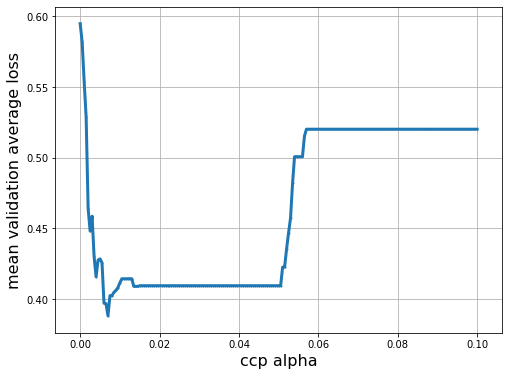

In [42]:
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation average loss', fontsize=16)
plt.scatter(ccp, mean_avgloss, s=1)
plt.plot(ccp, mean_avgloss, linewidth=3)
plt.grid(True, which='both')
plt.show()

In [44]:
print('Grid best parameter (min. Avg Loss): ', dtc_cv_avgloss.best_params_['ccp_alpha'])
print('Grid best score (Avg Loss): ', dtc_cv_avgloss.best_score_*(-1))

Grid best parameter (min. Avg Loss):  0.007
Grid best score (Avg Loss):  -0.38820558558952917


Node count = 11


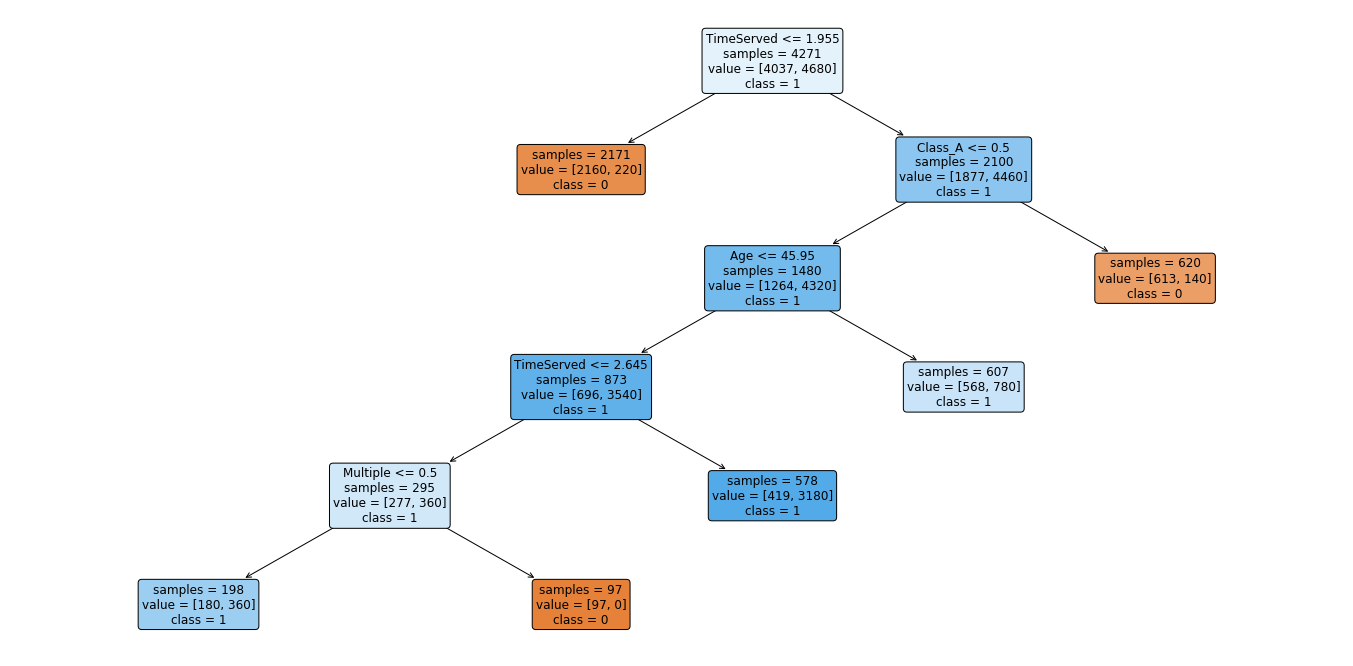

In [45]:
print('Node count =', dtc_cv_avgloss.best_estimator_.tree_.node_count)

plt.figure(figsize=(24,12))
plot_tree(dtc_cv_avgloss.best_estimator_, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=12)
plt.show()

In [46]:
y_pred = dtc_cv_avgloss.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm)
print('Precision:',precision_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))

Confusion Matrix : 
 [[1239  491]
 [   7   94]]
Precision: 0.1606837606837607
Recall: 0.9306930693069307


# ------------------------------------------------------------------------------------------
# EXTRA

In [35]:
# ## Cross-validation with Class Weights

# dt = DecisionTreeClassifier(class_weight = {0: 1, 1: 20})
# clf_weights = GridSearchCV(dt, param_grid = grid_values, cv=10)
# clf_weights.fit(X_train, y_train)

# ccp = clf_weights.cv_results_['param_ccp_alpha'].data
# acc = clf_weights.cv_results_['mean_test_score']

# pd.DataFrame({'ccp alpha' : ccp, 'Mean Validation Accuracy': acc}).head()

# plt.figure(figsize=(8, 6))
# plt.xlabel('ccp alpha', fontsize=16)
# plt.ylabel('mean validation accuracy', fontsize=16)
# plt.scatter(ccp, acc)
# plt.plot(ccp, acc)
# plt.show()

# print('Grid best parameter (max. Accuracy): ', clf_weights.best_params_)
# print('Grid best score (Accuracy): ', clf_weights.best_score_)

# print('Node count =', clf_weights.best_estimator_.tree_.node_count)

# plt.figure(figsize=(30,15))
# plot_tree(clf_weights.best_estimator_, 
#           feature_names=X_train.columns, 
#           class_names=['0','1'], 
#           filled=True,
#           impurity=False,
#           rounded=True,
#           fontsize=10,
#           max_depth = 5,
#           label='root')
# plt.show()

# y_pred = clf_weights.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# print ("Confusion Matrix : \n", cm) 

# print('Precision:',precision_score(y_test, y_pred))
# print('Recall:',recall_score(y_test, y_pred))

In [36]:
# # minbucket hasnt persisted throughout the code.
# rpart default values:
#     rpart.control(minsplit = 20, minbucket = round(minsplit/3), cp = 0.01, 
#               maxcompete = 4, maxsurrogate = 5, usesurrogate = 2, xval = 10,
#               surrogatestyle = 0, maxdepth = 30, ...)
    
#     Use r defaults.
#     minsplit = 2 default in sklearn.
#     minbucket = 1. sklearn.
#     max_depth = no bound in sklearn.
    
# min_samples_leaf.
# min_samples_split
# minsplit = 20
# maxdepth = 30

In [37]:
# weights = np.array([20 if i == 1 else 1 for i in y_test])
# print(np.sum(np.multiply(weights,(y_test != y_pred)))/len(y_test))
# print((weights@(y_test != y_pred))/len(y_test))
# print(np.dot(weights, (y_test != y_pred))/len(y_test))
# print(np.mean(weights*(y_test != y_pred)))
# print(np.mean(20*(y_test != y_pred)))

In [38]:
# ## ONE-HOT ENCODING
# from sklearn.preprocessing import OneHotEncoder

# ohe = OneHotEncoder()
# encoding = ohe.fit_transform(parole['Class'].values.reshape(-1,1)).toarray()

# encoding = pd.DataFrame(encoding, columns=["Class_"+str(int(i)) for i in range(encoding.shape[1])])
# # [i for i in parole['Class'].unique()]

# parole_enc = pd.concat([parole, encoding], axis=1)
# parole_enc.drop(['Class'], axis=1, inplace=True)
# parole_enc.head()

In [39]:
# ## OTHER TREE VISUALIZATIONS
# from dtreeviz.trees import dtreeviz # remember to load the package

# viz = dtreeviz(mod, X_train, y_train,
#                 target_name="target",
#                 feature_names=X_train.columns,
#                 class_names=['0', '1'])
# viz

# def GetDecisionTreeGraphViz(dt):
#   from IPython.display import Image
#   return graphviz.Source(sklearn.tree.export_graphviz(
#       dt, out_file=None, filled=True, impurity=False,
#       feature_names=features,
#       class_names=['takes loan', 'otherwise']))

# dt = sklearn.tree.DecisionTreeClassifier(max_depth=5,random_state=88)
# dt.fit(X_train, Y_train)
# display(Image(GetDecisionTreeGraphViz(dt).pipe(format='png'), width=900))

# import graphviz
# from sklearn import tree
# # DOT data
# dot_data = tree.export_graphviz(clf_avg_loss.best_estimator_, out_file=None, 
#                                 feature_names=X_train.columns,  
#                                 class_names=['0', '1'],
#                                 filled=True)

# graph = graphviz.Source(dot_data, format="png") 
# graph

# graphviz.Source(tree.export_graphviz(clf_avg_loss.best_estimator_,
#                                      out_file=None,
#                                      filled=True,
#                                      impurity=False,
#                                      feature_names=X_train.columns,
#                                      class_names=['0', '1']))